In [1]:
import os
import glob
import codecs
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

filepath -> ./experimental_data/txt/0713-main.TXT
 Oxy-Hb data


/Users/human/.local/share/virtualenvs/nirs-analysis-cPFDHTrY/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Time(sec),Mark,ch-1,ch-2,ch-3,ch-4,ch-5,ch-6,ch-7,ch-8,...,ch-13,ch-14,ch-15,ch-16,ch-17,ch-18,ch-19,ch-20,ch-21,ch-22
0,0.000,0Z,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.150,0,-0.010916,0.003867,0.006667,0.003237,0.002989,0.004922,0.004623,0.002248,...,0.008919,0.003507,0.005177,0.002709,0.007292,0.003441,0.003417,0.008807,0.006464,0.002820
2,0.300,0,0.001431,0.003377,0.007147,0.003741,0.002111,0.003658,0.005710,0.002564,...,0.010347,0.002795,0.005039,0.005042,0.006374,0.002175,0.002802,0.010716,0.006633,0.002474
3,0.450,0,-0.002045,0.001742,0.004772,0.002395,-0.003275,0.000927,0.003333,-0.000010,...,0.006198,0.000844,0.003133,0.001365,0.002798,0.000594,0.000109,0.007197,0.003833,-0.000237
4,0.600,0,0.001474,0.000238,0.000823,-0.000762,-0.005549,-0.002680,-0.000588,-0.001397,...,0.000255,-0.001728,-0.001860,0.001166,-0.001348,-0.001288,-0.002298,0.002399,-0.000579,-0.002828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11582,1737.3,0,-0.071698,-0.058509,-0.042237,0.033209,-0.065773,0.063947,0.073778,0.029932,...,-0.037005,-0.027884,0.006887,-0.015162,-0.029784,-0.028576,-0.009314,-0.06178,-0.00106,0.070055
11583,1737.45,0,-0.064951,-0.058814,-0.042617,0.030935,-0.067479,0.064016,0.071132,0.029542,...,-0.040981,-0.027485,0.007266,-0.015991,-0.03161,-0.030835,-0.010556,-0.059402,-0.003844,0.06796
11584,1737.6,0,-0.066047,-0.060842,-0.045839,0.026885,-0.071183,0.065581,0.068064,0.027026,...,-0.047664,-0.030606,0.004814,-0.017076,-0.035312,-0.032719,-0.011985,-0.054567,-0.009187,0.06607
11585,1737.75,0,-0.073903,-0.063848,-0.049477,0.024036,-0.073848,0.067346,0.066408,0.026018,...,-0.053574,-0.032306,0.001804,-0.023427,-0.040371,-0.037321,-0.015537,-0.04871,-0.014751,0.063313



Marker Indexes -> [  63 1317 2483 2484 3608 4768 4769 5894 5895 7046]



Trial Count -> 1 / 10
Z-normalized Data


,Time(sec),ch-1,ch-2,ch-3,ch-4,ch-5,ch-6,ch-7,ch-8,ch-9,...,ch-13,ch-14,ch-15,ch-16,ch-17,ch-18,ch-19,ch-20,ch-21,ch-22
0,54.45,-0.906385,-0.699320,-0.884075,-0.931008,-1.612371,-1.696972,-1.013573,-0.157827,-1.396287,...,-1.946029,-1.598864,-0.870275,-1.830638,-1.613174,-1.812859,-1.208524,-1.093484,-1.835730,-1.496021
1,54.60,-0.621400,-0.605045,-0.640625,-0.447928,-1.070276,-1.403980,-0.775450,0.373833,-1.183165,...,-1.914125,-1.236409,-0.689503,-1.289207,-1.189841,-1.621371,-0.988175,-0.951504,-1.818983,-1.366338
2,54.75,-1.118204,0.167800,0.153498,0.149735,-0.572543,-0.632268,-0.253235,0.636035,-0.322825,...,-0.661245,-0.386646,-0.310829,-0.160417,-0.035737,-0.805661,-0.077566,0.314084,-0.644460,-0.656295
3,54.90,-0.338360,0.212411,0.309093,0.428592,-0.425326,-0.649551,-0.214946,1.167303,-0.225035,...,-0.575116,-0.439747,0.291174,0.017180,-0.051421,-0.791470,0.055152,0.259294,-0.668257,-0.803017
4,55.05,0.089066,0.068820,0.036631,0.088351,-0.815823,-0.942082,-0.373964,0.790964,-0.306984,...,-1.083037,-0.721625,-0.123601,-0.903885,-0.517920,-1.077086,-0.456034,-0.168316,-0.972465,-1.060943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,83.70,-1.299939,-2.226190,-0.940046,-1.110288,-1.463292,-0.982407,-1.070250,-1.373723,-2.800558,...,-2.719859,-1.810130,-2.023292,-2.612870,-2.962289,-2.331637,-1.039611,-3.530794,-2.320246,-1.238648
196,83.85,-1.459060,-1.435396,-0.169734,-0.299828,-0.511531,-0.140530,-0.536518,-0.575154,-1.957498,...,-1.530788,-1.083226,-1.155268,-1.903321,-1.663697,-1.727175,-0.063384,-2.217370,-1.202509,-0.737291
197,84.00,-0.964916,-1.232209,0.313335,-0.000899,-0.534424,0.038284,-0.262530,-0.299420,-1.727358,...,-0.990842,-0.831387,-1.225100,-0.958871,-1.558210,-1.493294,0.018744,-1.886267,-0.878030,-0.639255
198,84.15,-1.390909,-1.325438,0.158014,-0.200835,-0.778909,-0.199174,-0.413870,-1.011896,-2.005542,...,-1.462734,-0.992826,-1.225627,-1.409712,-1.877445,-1.756275,-0.247115,-2.264511,-1.136153,-0.815189



Summary Statistics


,ch-1,ch-2,ch-3,ch-4,ch-5,ch-6,ch-7,ch-8,ch-9,ch-10,...,ch-13,ch-14,ch-15,ch-16,ch-17,ch-18,ch-19,ch-20,ch-21,ch-22
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,-1.016594,-0.787528,-0.118736,-0.301295,-0.241054,-0.240045,-0.430991,-0.832261,-1.089072,-0.682294,...,-1.252565,-0.643118,-0.765673,-1.581660,-0.939473,-1.469436,-0.445755,-1.753325,-0.743237,-0.133988
std,0.699182,1.084795,0.720384,0.610268,0.838908,0.698518,0.832348,0.638230,1.133653,1.043433,...,0.832078,0.802890,1.211845,0.859404,1.085103,0.741543,0.628728,0.874227,0.733553,0.983971
min,-2.630515,-2.759428,-1.785623,-1.802852,-1.704929,-1.696972,-2.085381,-2.117577,-3.083455,-2.749080,...,-3.239426,-2.255583,-2.650198,-3.534988,-3.176454,-2.989989,-2.073623,-3.863982,-2.320246,-1.812481
25%,-1.516338,-1.676878,-0.643977,-0.757185,-0.845562,-0.740743,-1.094143,-1.302730,-2.069066,-1.472178,...,-1.830816,-1.249648,-1.862613,-2.091136,-1.792709,-2.048492,-0.913455,-2.366094,-1.209151,-0.921164
50%,-1.048723,-1.038954,-0.126149,-0.271377,-0.381895,-0.254996,-0.581223,-0.889620,-1.284424,-0.809320,...,-1.287260,-0.722978,-0.883517,-1.485766,-1.006628,-1.537393,-0.462384,-1.834328,-0.752116,-0.419669
75%,-0.551638,0.229401,0.359418,0.150368,0.393841,0.220554,0.241500,-0.450770,-0.070332,0.183310,...,-0.622851,-0.084125,0.235638,-1.048881,-0.073524,-0.852500,0.037160,-1.106417,-0.209302,0.696267
max,0.684719,1.220159,1.564116,1.008132,1.744259,1.485041,1.241275,1.167303,1.126611,1.387698,...,0.716462,1.300351,1.680566,0.526800,1.160284,0.057292,1.064610,0.330771,1.005388,2.067475


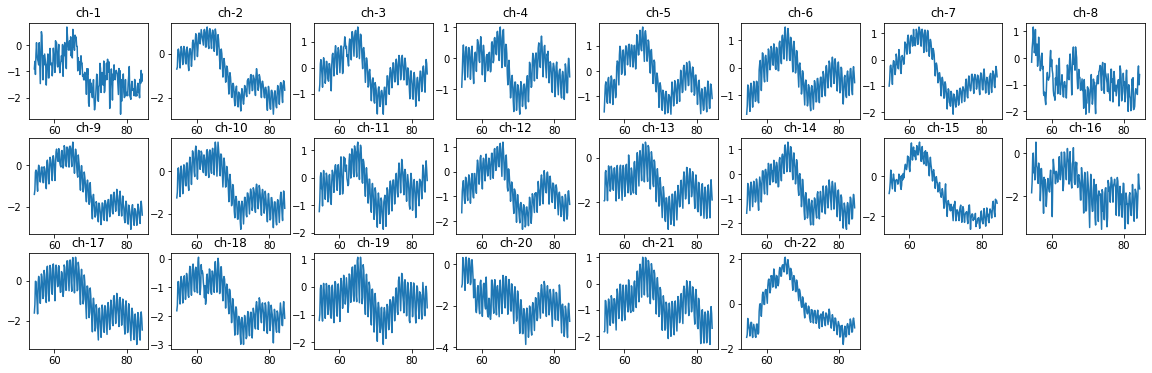





Trial Count -> 2 / 10
Z-normalized Data


,Time(sec),ch-1,ch-2,ch-3,ch-4,ch-5,ch-6,ch-7,ch-8,ch-9,...,ch-13,ch-14,ch-15,ch-16,ch-17,ch-18,ch-19,ch-20,ch-21,ch-22
0,242.55,0.936968,1.415743,1.270828,1.480809,0.052679,1.270235,0.119827,1.637902,0.667295,...,0.341843,2.170680,-0.720542,1.136724,1.599390,0.392816,0.298599,1.357597,0.564649,-0.458393
1,242.70,1.040506,1.031390,0.879332,0.869063,-0.800858,1.549859,-0.437065,1.419463,0.366986,...,-0.085142,1.770741,-1.122837,0.804115,0.904205,0.097202,-0.120639,0.837849,0.066065,-0.676158
2,242.85,0.157116,0.693414,0.279693,0.259646,-1.375102,1.865776,-0.644708,0.638533,-0.113023,...,-0.807671,1.268160,-1.142095,0.187382,0.258426,-0.378094,-0.837613,0.072643,-0.664040,-0.889433
3,243.00,-0.021177,0.600225,0.068635,0.474433,-0.624764,2.058508,-0.629828,1.125795,-0.154188,...,-0.869045,1.521269,-1.069657,0.372089,0.362143,-0.309460,-0.619158,-0.045957,-0.676226,-0.799793
4,243.15,0.937229,1.518995,1.353028,1.373881,0.373892,1.275957,0.269457,1.658435,0.971098,...,0.596954,2.624876,-0.796425,1.295763,1.890568,0.467619,0.423781,1.561600,0.845081,-0.561823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,271.80,0.890214,0.106057,-0.640724,1.040286,-1.865508,3.163056,1.330242,1.915869,-0.022338,...,-1.469089,3.948310,2.264871,3.798279,0.360741,-2.297270,-1.743343,-0.058580,0.310787,3.230145
196,271.95,0.704367,0.309718,-0.722013,1.410921,-1.257089,3.309125,1.386917,2.492680,-0.029173,...,-1.746722,3.932089,1.977858,3.669391,0.529632,-2.007312,-1.320914,-0.148971,0.181318,3.235597
197,272.10,1.206557,1.155643,0.178174,2.146601,-0.525100,2.681045,2.107147,2.500962,0.879502,...,-0.357111,4.893900,2.375029,4.541727,1.898627,-1.232546,-0.489067,1.353234,1.478549,3.491848
198,272.25,1.031129,1.240083,0.526292,2.187368,-0.668367,2.644573,1.902347,2.718366,0.841982,...,-0.471562,4.902849,2.398439,4.563185,1.654051,-1.398090,-0.695740,0.993072,1.396129,3.346965



Summary Statistics


,ch-1,ch-2,ch-3,ch-4,ch-5,ch-6,ch-7,ch-8,ch-9,ch-10,...,ch-13,ch-14,ch-15,ch-16,ch-17,ch-18,ch-19,ch-20,ch-21,ch-22
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,1.415353,1.369425,0.212082,1.304222,-0.110587,2.137293,1.982980,2.406868,1.270727,1.625334,...,-0.110259,4.357698,0.953891,2.919969,1.995888,-0.464332,-0.693368,1.005654,1.169698,1.833267
std,0.999506,1.408769,1.537729,1.429480,1.524953,0.928624,1.374041,0.950400,0.943366,1.445680,...,1.327331,1.264816,1.682547,1.196778,1.316871,1.557041,1.413170,1.336118,1.279274,2.016376
min,-1.839661,-1.766922,-3.561274,-2.382788,-3.545479,0.375048,-0.644708,0.056201,-0.894100,-1.707772,...,-3.246701,1.268160,-1.369302,0.087830,-1.148588,-3.406722,-3.928630,-2.304952,-1.777815,-0.889433
25%,0.853162,0.408213,-0.708070,0.463135,-1.229816,1.313994,0.818657,1.840123,0.596471,0.654573,...,-1.112204,3.450624,-0.612459,2.043795,1.007528,-1.774998,-1.796361,0.030174,0.269027,-0.112141
50%,1.430432,1.482135,0.533856,1.535670,0.007730,1.996469,1.878439,2.600002,1.188621,1.792896,...,0.008566,4.346011,0.270841,2.655604,2.002958,-0.536825,-0.479003,1.218271,1.213603,1.338691
75%,2.100203,2.333365,1.356992,2.342227,1.020864,2.956154,3.040998,3.115949,1.968598,2.655572,...,0.854205,5.223220,2.704047,4.024308,3.031500,0.640232,0.383587,2.003971,2.096279,3.876325
max,4.241835,4.563406,2.839366,3.848587,3.196459,4.063786,4.711044,4.132184,3.592311,4.704271,...,3.010038,7.025881,3.704971,5.163077,4.892232,3.075191,2.038385,3.437369,3.736054,5.026707


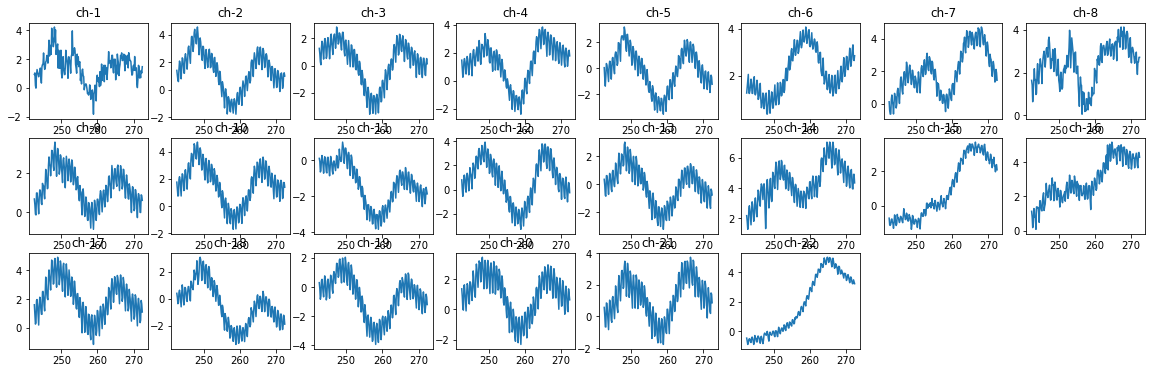





Trial Count -> 3 / 10
Z-normalized Data


,Time(sec),ch-1,ch-2,ch-3,ch-4,ch-5,ch-6,ch-7,ch-8,ch-9,...,ch-13,ch-14,ch-15,ch-16,ch-17,ch-18,ch-19,ch-20,ch-21,ch-22
0,417.45,-0.805337,-1.480010,-2.465996,-2.228834,-2.568867,2.752572,-1.451242,0.162863,-0.402008,...,-1.634812,-0.923838,1.086888,0.385920,-0.822466,-0.887281,-1.506611,-0.710649,-1.645422,0.408232
1,417.60,-1.606313,-1.987958,-3.022523,-2.755922,-3.121092,3.226543,-2.048827,0.036156,-1.184490,...,-2.274601,-1.738211,0.290314,0.121917,-1.594525,-1.543458,-2.102215,-1.222525,-2.411794,-0.270865
2,417.75,-0.906153,-1.961034,-3.171148,-2.413865,-2.439935,3.360823,-1.873880,0.018960,-0.928412,...,-2.595691,-1.559407,0.597472,-0.087202,-1.438021,-1.468688,-1.925999,-1.350236,-2.615914,0.215045
3,417.90,0.337082,-0.976629,-1.898537,-1.479612,-1.744289,2.270292,-1.060602,0.791096,0.035893,...,-0.670004,-0.086800,1.407626,1.495329,0.041908,-0.572676,-0.861695,-0.090086,-0.793368,1.181470
4,418.05,-0.122699,-0.770613,-1.758351,-1.457111,-1.768315,2.201822,-0.797489,0.844882,0.171157,...,-0.934733,-0.197293,0.952160,0.526015,-0.182389,-0.672369,-0.923093,-0.109257,-0.778184,1.335186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,446.70,-0.759556,-0.000877,-1.227713,-1.230429,-2.395001,4.361945,0.555134,-0.401111,0.287756,...,-1.839251,2.225993,-0.616687,-0.407951,-0.462400,-1.642538,-1.157080,-0.762854,-0.919180,-1.767328
196,446.85,-0.274108,-0.078524,-1.378639,-1.025291,-1.724482,4.410472,0.589664,-0.444554,0.322074,...,-2.148385,2.191680,-0.545928,-0.849072,-0.467809,-1.589627,-1.056282,-1.023290,-1.206597,-1.550605
197,447.00,0.132981,0.990499,-0.237202,-0.349794,-1.040024,3.273740,1.459339,0.303404,1.430874,...,-0.329102,3.348234,0.216696,0.453642,1.152396,-0.555107,0.077155,0.199107,0.677554,-0.391974
198,447.15,0.390513,1.219593,-0.231257,-0.193008,-0.963545,3.311631,1.731199,0.216261,1.486465,...,-0.767185,3.205632,0.143078,-0.135761,0.975338,-0.730387,-0.013008,0.246446,0.629181,-0.917599



Summary Statistics


,ch-1,ch-2,ch-3,ch-4,ch-5,ch-6,ch-7,ch-8,ch-9,ch-10,...,ch-13,ch-14,ch-15,ch-16,ch-17,ch-18,ch-19,ch-20,ch-21,ch-22
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,-0.425394,-0.446150,-1.867430,-1.460435,-1.858491,3.426092,-0.081647,-0.036948,0.318468,-1.544250,...,-1.406972,1.295842,0.160147,0.290656,-0.249561,-1.375398,-1.195085,-0.684265,-0.397056,1.385097
std,0.738065,0.995428,1.050136,0.939183,0.745118,0.794766,1.473620,0.610512,0.872170,1.023910,...,0.837270,1.305310,0.635242,0.641030,0.839728,0.606508,0.760351,0.651195,1.092575,1.444203
min,-3.133980,-3.039913,-4.506276,-3.753369,-3.690190,1.182420,-3.771144,-1.535913,-2.031994,-4.169386,...,-3.137958,-1.951641,-1.347506,-1.231031,-2.552476,-2.890745,-3.287622,-2.421179,-3.076214,-1.805573
25%,-0.800802,-1.068398,-2.573629,-2.163965,-2.359421,2.975099,-1.257361,-0.521677,-0.309089,-2.251066,...,-2.031734,0.519021,-0.261642,-0.101296,-0.870562,-1.799994,-1.715157,-1.154430,-1.156760,0.432686
50%,-0.426258,-0.327931,-1.736680,-1.354542,-1.834615,3.466353,0.247364,0.021805,0.390609,-1.562254,...,-1.364960,1.557842,0.199899,0.319779,-0.261182,-1.356840,-1.190680,-0.664638,-0.370920,1.308586
75%,0.047559,0.375576,-1.072232,-0.736613,-1.319942,3.990928,1.036644,0.436640,0.975764,-0.694517,...,-0.755956,2.285016,0.561735,0.702854,0.385611,-0.987179,-0.625412,-0.169205,0.473814,2.430565
max,1.609808,1.471764,-0.003813,0.315170,-0.334291,5.077886,2.503502,1.236251,2.291223,0.302064,...,0.473623,3.565442,1.930813,1.747425,1.447011,0.093511,0.388251,0.621615,2.031123,4.673789


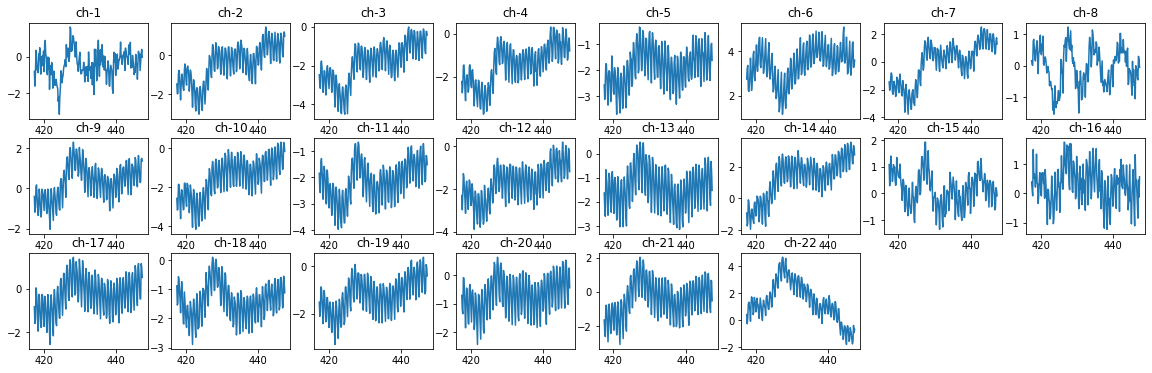





Trial Count -> 4 / 10
Z-normalized Data


,Time(sec),ch-1,ch-2,ch-3,ch-4,ch-5,ch-6,ch-7,ch-8,ch-9,...,ch-13,ch-14,ch-15,ch-16,ch-17,ch-18,ch-19,ch-20,ch-21,ch-22
0,417.60,-1.623646,-1.994265,-2.990473,-2.729578,-3.078678,3.178052,-2.036300,0.027913,-1.188444,...,-2.263968,-1.731728,0.286869,0.117055,-1.602353,-1.553576,-2.103904,-1.229449,-2.397527,-0.268455
1,417.75,-0.918093,-1.967275,-3.137786,-2.390118,-2.404853,3.310676,-1.861945,0.010551,-0.931972,...,-2.583959,-1.553084,0.593449,-0.092470,-1.445342,-1.478473,-1.927580,-1.357582,-2.600789,0.218818
2,417.90,0.334716,-0.980460,-1.876408,-1.462959,-1.716695,2.233597,-1.051424,0.790139,0.033818,...,-0.664865,-0.081786,1.402079,1.493130,0.039390,-0.578467,-0.862620,-0.093268,-0.785908,1.187954
3,418.05,-0.128606,-0.773940,-1.737459,-1.440630,-1.740462,2.165972,-0.789204,0.844444,0.169290,...,-0.928687,-0.192181,0.947470,0.521936,-0.185636,-0.678605,-0.924055,-0.112503,-0.770788,1.342102
4,418.20,-0.738907,-0.966724,-2.060406,-1.856105,-2.312143,2.440740,-0.922952,0.519659,-0.389482,...,-1.226040,-0.716791,0.932667,0.662302,-0.615969,-1.081206,-1.309356,-0.562152,-1.177527,1.052983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,446.85,-0.281181,-0.080157,-1.361098,-1.012089,-1.697101,4.347376,0.593247,-0.457437,0.320439,...,-2.138185,2.194668,-0.547799,-0.855817,-0.471982,-1.599951,-1.057326,-1.029556,-1.197399,-1.551786
196,447.00,0.129044,0.991483,-0.229736,-0.341722,-1.020010,3.224667,1.459975,0.297740,1.430947,...,-0.325130,3.350194,0.213390,0.449423,1.153481,-0.560820,0.076809,0.196880,0.678827,-0.389904
197,447.15,0.388559,1.221137,-0.223843,-0.186126,-0.944354,3.262091,1.730913,0.209756,1.486623,...,-0.761713,3.207719,0.139910,-0.141123,0.975849,-0.736881,-0.013409,0.244375,0.630658,-0.917004
198,447.30,-0.038826,0.993651,-0.407271,-0.789267,-1.591509,3.544738,1.280343,-0.055894,1.354367,...,-1.516245,2.762366,-0.091407,0.558845,0.522904,-1.131685,-0.400404,-0.449259,-0.512445,-0.693036



Summary Statistics


,ch-1,ch-2,ch-3,ch-4,ch-5,ch-6,ch-7,ch-8,ch-9,ch-10,...,ch-13,ch-14,ch-15,ch-16,ch-17,ch-18,ch-19,ch-20,ch-21,ch-22
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,-0.429034,-0.439140,-1.839213,-1.440320,-1.828693,3.381920,-0.064510,-0.047267,0.323198,-1.512823,...,-1.402442,1.314601,0.149215,0.284786,-0.249603,-1.387978,-1.193083,-0.690127,-0.387646,1.383723
std,0.744212,0.997029,1.041112,0.930480,0.736293,0.785044,1.466750,0.616258,0.872869,1.012513,...,0.836434,1.295724,0.632137,0.642351,0.841496,0.608305,0.760820,0.653455,1.085024,1.458855
min,-3.163078,-3.048795,-4.461130,-3.719450,-3.641650,1.159145,-3.752779,-1.559329,-2.037254,-4.120457,...,-3.124369,-1.944969,-1.347868,-1.238515,-2.563413,-2.906867,-3.290041,-2.432063,-3.059153,-1.807469
25%,-0.811278,-1.034259,-2.545541,-2.136771,-2.325206,2.935537,-1.217004,-0.535304,-0.308028,-2.188240,...,-2.041336,0.533011,-0.269354,-0.106590,-0.876041,-1.811255,-1.716607,-1.161128,-1.133245,0.437070
50%,-0.426544,-0.318125,-1.694310,-1.338839,-1.806048,3.422126,0.265758,0.011530,0.394708,-1.527534,...,-1.357441,1.591115,0.194217,0.311293,-0.259438,-1.371256,-1.177174,-0.669718,-0.365237,1.315427
75%,0.055585,0.381200,-1.057396,-0.725603,-1.296915,3.935716,1.038713,0.432262,0.975136,-0.681080,...,-0.750522,2.287922,0.548283,0.699118,0.384208,-1.003282,-0.626191,-0.172648,0.475944,2.440555
max,1.617245,1.473925,0.001593,0.318193,-0.321873,5.006558,2.500598,1.239590,2.292620,0.305322,...,0.474848,3.567208,1.924282,1.745715,1.449053,0.090689,0.388097,0.620784,2.026703,4.690073


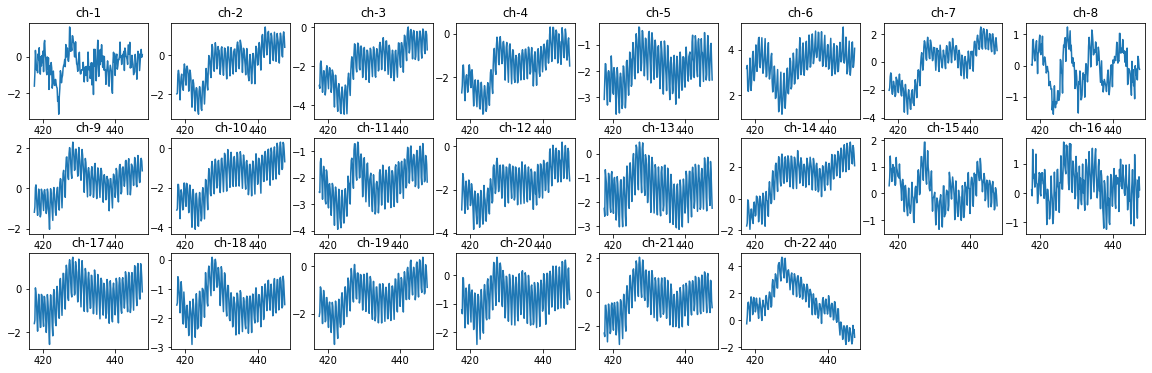





Trial Count -> 5 / 10
Z-normalized Data


,Time(sec),ch-1,ch-2,ch-3,ch-4,ch-5,ch-6,ch-7,ch-8,ch-9,...,ch-13,ch-14,ch-15,ch-16,ch-17,ch-18,ch-19,ch-20,ch-21,ch-22
0,586.20,1.562077,1.540086,-0.394772,0.985635,0.037471,0.092668,1.255611,1.983429,1.798566,...,1.026177,2.240812,0.560467,2.461369,2.098776,0.695641,-0.014487,0.688244,1.391735,-0.113735
1,586.35,0.953132,1.159206,-0.780991,0.733173,-0.430339,0.396186,1.137253,1.955388,1.538471,...,0.760884,1.885845,0.459904,2.584433,1.842675,0.460097,-0.455256,0.448003,0.993761,-0.168697
2,586.50,1.446519,0.689313,-1.420415,0.403541,-0.433822,0.803506,0.685370,1.649955,1.101627,...,0.380162,1.221161,0.275292,2.207816,1.324055,-0.136096,-0.893839,0.085666,0.229292,-0.312942
3,586.65,0.727922,0.350647,-1.868011,-0.204617,-0.988864,1.274175,0.516066,1.702514,0.653202,...,0.019799,0.994367,0.055294,1.564007,0.891213,-0.522846,-1.365396,-0.266841,-0.460009,-0.453325
4,586.80,1.255890,0.887585,-0.963148,1.002756,0.118948,0.547818,0.949604,1.995149,1.513411,...,0.676791,1.881782,0.523247,2.142496,1.841441,0.380073,-0.438570,0.459486,0.998149,-0.158102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,615.45,0.259114,0.724269,-1.042484,0.097929,-0.781689,1.478217,1.265668,0.497104,0.176489,...,0.727158,2.036734,0.098542,0.504328,1.291472,0.654011,0.399267,0.563851,1.410623,-0.282206
196,615.60,0.391821,0.381400,-1.760059,-0.744038,-1.370200,1.811502,0.878655,0.431531,0.088969,...,0.459475,1.550825,-0.479409,0.213038,1.004145,0.171276,-0.007336,0.318465,0.796682,-0.524455
197,615.75,0.758979,0.182555,-1.992146,-1.284992,-1.867088,2.389026,0.732669,0.328282,-0.571898,...,0.107167,1.308333,-0.469711,0.069666,0.637704,-0.377249,-0.502928,0.083553,0.209260,-0.547576
198,615.90,0.571780,0.107678,-2.281465,-0.841394,-0.986593,2.283444,0.859758,0.393208,-0.381859,...,0.253313,1.292635,-0.303621,-0.003081,0.637334,0.101389,-0.122941,0.123057,0.246462,-0.442565



Summary Statistics


,ch-1,ch-2,ch-3,ch-4,ch-5,ch-6,ch-7,ch-8,ch-9,ch-10,...,ch-13,ch-14,ch-15,ch-16,ch-17,ch-18,ch-19,ch-20,ch-21,ch-22
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,1.564343,1.709083,-0.466470,0.533993,0.048065,0.827477,0.966285,1.157909,2.725030,2.326940,...,0.758291,2.232662,0.147701,3.116789,2.213536,1.367446,0.595438,0.623938,1.404601,-0.230346
std,0.745528,0.830383,1.052825,1.015965,0.921916,0.768014,0.580261,0.546197,1.762730,0.871753,...,0.476205,0.632398,0.493327,1.282971,0.752802,0.864884,0.725382,0.485827,0.965868,0.204723
min,-0.210932,0.107678,-2.942005,-1.898516,-1.993543,-0.535485,-0.325812,0.032484,-0.571898,-0.114128,...,-0.256559,0.994367,-0.871962,-0.003081,0.514158,-0.522846,-1.365396,-0.457656,-0.518579,-0.642710
25%,1.084124,1.049134,-1.187933,-0.174656,-0.571030,0.182095,0.564084,0.711960,1.283218,1.705816,...,0.420261,1.769678,-0.215771,2.287838,1.678123,0.753503,0.063030,0.269315,0.731481,-0.376747
50%,1.561458,1.693183,-0.488613,0.611797,0.007334,0.818898,0.913909,1.102146,2.740505,2.304552,...,0.795363,2.231300,0.097756,3.402228,2.246389,1.322788,0.580719,0.617274,1.454694,-0.239274
75%,2.027836,2.342676,0.284714,1.216314,0.731766,1.317744,1.301335,1.425680,4.270409,2.887279,...,1.021397,2.604550,0.513221,4.104349,2.814564,1.971504,1.069905,0.907125,1.969093,-0.107610
max,3.977946,3.426532,1.745716,2.836173,1.958689,2.582637,2.463062,2.611191,5.913369,4.448150,...,1.728846,3.968916,1.159037,5.266517,3.676112,3.378944,2.453738,1.869237,3.758594,0.412480


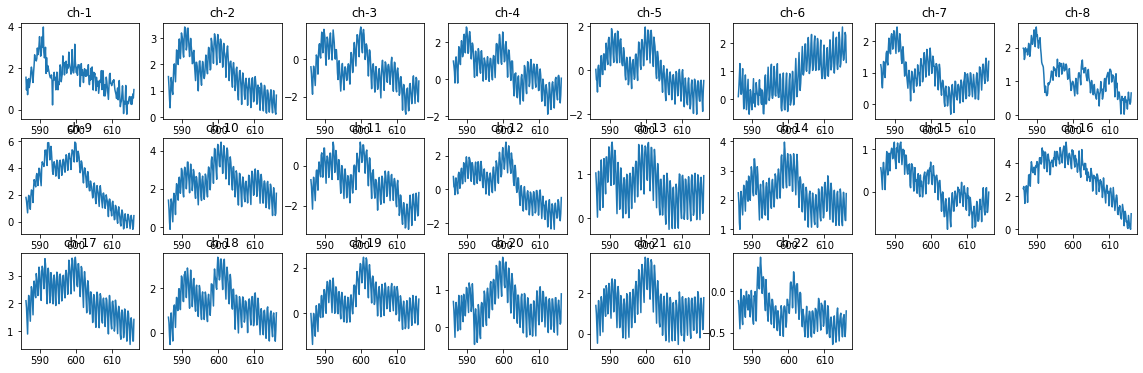





Trial Count -> 6 / 10
Z-normalized Data


,Time(sec),ch-1,ch-2,ch-3,ch-4,ch-5,ch-6,ch-7,ch-8,ch-9,...,ch-13,ch-14,ch-15,ch-16,ch-17,ch-18,ch-19,ch-20,ch-21,ch-22
0,760.20,1.024584,0.932212,0.386764,0.471782,0.431584,0.173082,0.164439,0.669752,0.491384,...,0.910250,0.812866,-1.572732,-0.143152,0.707027,0.747607,0.498339,1.193427,0.888145,-1.906177
1,760.35,0.881899,0.714052,0.156330,0.468485,0.673885,0.375492,0.023685,0.512002,0.361211,...,0.754711,0.687986,-1.527278,-0.197570,0.604627,0.618993,0.494394,1.063207,0.633803,-1.985728
2,760.50,1.136465,1.168142,0.666477,0.911355,1.118104,-0.326902,0.575881,0.868903,0.823483,...,1.411700,1.275077,-1.158848,0.273939,1.260401,1.281576,1.152535,1.578138,1.467193,-1.554682
3,760.65,1.277824,1.274034,0.796954,0.946869,0.988341,-0.548828,0.672445,0.834991,0.895069,...,1.487967,1.229465,-1.053565,0.267277,1.329386,1.361479,1.312897,1.664803,1.534215,-1.396612
4,760.80,1.063405,1.178282,0.634371,0.741437,0.793601,-0.338798,0.549513,0.854647,0.843900,...,1.334127,1.089861,-1.145581,0.339777,1.103858,1.093065,0.974118,1.515401,1.284647,-1.767048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,789.45,-0.160842,0.587253,-0.343084,0.344716,0.258758,0.599834,-0.108523,-0.124401,0.221455,...,0.882410,0.233636,-1.439562,-0.451752,0.851714,-0.231481,0.166386,0.730851,0.936073,-1.387658
196,789.60,-0.127326,0.386968,-0.458721,0.202338,0.095023,0.828079,-0.235729,-0.193376,-0.035224,...,0.692038,0.003250,-1.437719,-0.537921,0.648655,-0.546991,-0.127941,0.539540,0.648983,-1.724689
197,789.75,-0.263079,0.127518,-0.833537,-0.071145,-0.224122,1.001308,-0.462318,-0.319519,-0.234067,...,0.364686,-0.297547,-1.500987,-0.805686,0.361770,-0.743579,-0.285118,0.322781,0.294967,-1.816523
198,789.90,-0.197674,0.132326,-0.905589,-0.075505,-0.168810,1.335498,-0.553790,-0.368047,-0.356989,...,0.157584,-0.235771,-1.984036,-0.875764,0.199422,-0.770793,-0.482954,0.131660,0.042439,-1.760505



Summary Statistics


,ch-1,ch-2,ch-3,ch-4,ch-5,ch-6,ch-7,ch-8,ch-9,ch-10,...,ch-13,ch-14,ch-15,ch-16,ch-17,ch-18,ch-19,ch-20,ch-21,ch-22
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.282448,0.418918,0.098254,0.572916,0.750999,-0.208128,0.371865,-0.014991,0.496322,0.355469,...,0.799655,0.521273,-0.332948,-0.194629,0.802855,0.265888,0.400360,0.491342,0.967169,0.117733
std,0.416116,0.365190,0.527850,0.405580,0.572027,0.907344,0.487342,0.317413,0.344351,0.445544,...,0.399884,0.474271,0.778899,0.332245,0.451130,0.490618,0.440348,0.524040,0.508532,1.078789
min,-0.629105,-0.541910,-1.060052,-0.359197,-0.493697,-2.215689,-0.658173,-0.630053,-0.521164,-0.497907,...,-0.177283,-0.652148,-2.053447,-1.023186,-0.322444,-0.902266,-0.625566,-0.681758,-0.424522,-2.212788
25%,-0.062690,0.175812,-0.312074,0.286473,0.332778,-0.953648,0.014001,-0.226712,0.272540,0.056952,...,0.524604,0.219825,-0.979179,-0.419071,0.511763,-0.066736,0.089581,0.131644,0.637527,-0.639297
50%,0.246657,0.407823,0.110831,0.543768,0.741207,-0.013994,0.369114,-0.057982,0.493426,0.323414,...,0.808594,0.500666,-0.121498,-0.198219,0.818258,0.270552,0.407234,0.488168,0.966863,0.263059
75%,0.560330,0.649058,0.491272,0.829081,1.109731,0.516193,0.703860,0.163525,0.757625,0.654928,...,1.050105,0.903648,0.289530,0.065134,1.114823,0.598147,0.686883,0.801310,1.355369,0.971731
max,1.277824,1.396442,1.216569,1.464490,2.081663,1.402224,1.428590,0.868903,1.206751,1.405937,...,1.695984,1.535908,1.190424,0.531235,1.808717,1.429328,1.312897,1.758370,2.109826,1.993902


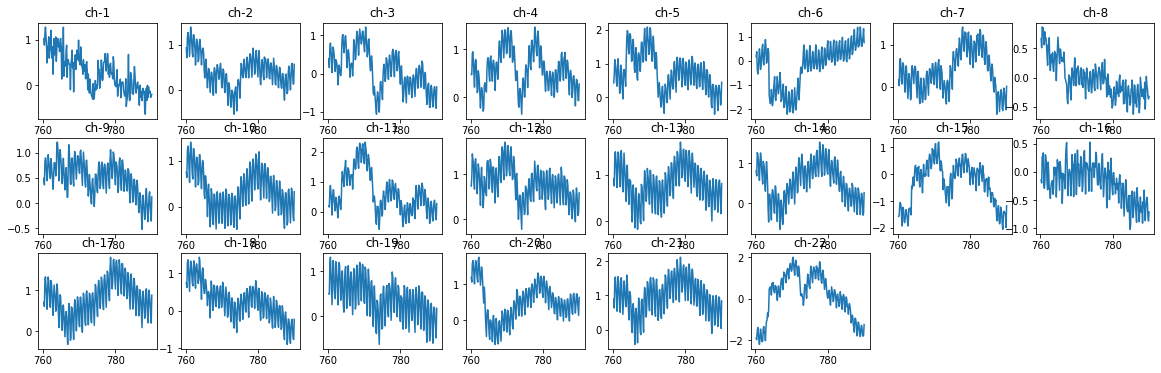





Trial Count -> 7 / 10
Z-normalized Data


,Time(sec),ch-1,ch-2,ch-3,ch-4,ch-5,ch-6,ch-7,ch-8,ch-9,...,ch-13,ch-14,ch-15,ch-16,ch-17,ch-18,ch-19,ch-20,ch-21,ch-22
0,760.35,0.879827,0.708384,0.151578,0.463181,0.669934,0.377380,0.017509,0.508297,0.355577,...,0.748878,0.682915,-1.526081,-0.202389,0.599042,0.613493,0.490988,1.056850,0.627597,-1.967813
1,760.50,1.137633,1.165588,0.662681,0.909636,1.114916,-0.325494,0.572415,0.872542,0.819744,...,1.409029,1.269735,-1.157854,0.270641,1.256702,1.276853,1.149172,1.573733,1.461698,-1.539341
2,760.65,1.280791,1.272205,0.793402,0.945438,0.984930,-0.547571,0.669452,0.837933,0.891624,...,1.485662,1.224144,-1.052628,0.263958,1.325885,1.356849,1.309545,1.660728,1.528778,-1.382216
3,760.80,1.063643,1.175797,0.630515,0.738343,0.789855,-0.337397,0.545917,0.857993,0.840245,...,1.331082,1.084604,-1.144593,0.336692,1.099708,1.088121,0.970743,1.510759,1.278996,-1.750439
4,760.95,0.842587,0.941722,0.370943,0.456106,0.452524,0.092064,0.157949,0.578471,0.564691,...,1.019952,0.766573,-1.340801,-0.235111,0.837692,0.854104,0.674424,1.258990,0.957549,-1.913726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,789.60,-0.142242,0.379058,-0.464625,0.194879,0.090078,0.830277,-0.243176,-0.211598,-0.042483,...,0.685904,-0.001505,-1.436572,-0.543839,0.643197,-0.553856,-0.131388,0.531197,0.642790,-1.708334
196,789.75,-0.279722,0.117828,-0.840144,-0.080818,-0.229615,1.003624,-0.470877,-0.340337,-0.242141,...,0.356978,-0.302163,-1.499805,-0.812468,0.355486,-0.750675,-0.288575,0.313615,0.288472,-1.799619
197,789.90,-0.213485,0.122670,-0.912330,-0.085213,-0.174208,1.338042,-0.562797,-0.389863,-0.365567,...,0.148879,-0.240416,-1.982590,-0.882772,0.192672,-0.777921,-0.486425,0.121769,0.035728,-1.743935
198,790.05,-0.213058,0.558824,-0.354662,0.264661,0.445430,0.758297,0.003529,-0.346583,0.114917,...,0.798391,0.260644,-1.174675,-0.722636,0.875943,-0.239096,0.173580,0.623275,0.833900,-1.242321



Summary Statistics


,ch-1,ch-2,ch-3,ch-4,ch-5,ch-6,ch-7,ch-8,ch-9,ch-10,...,ch-13,ch-14,ch-15,ch-16,ch-17,ch-18,ch-19,ch-20,ch-21,ch-22
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.267416,0.409140,0.089935,0.568094,0.747427,-0.204787,0.366482,-0.033591,0.489684,0.346973,...,0.793955,0.513522,-0.331259,-0.201198,0.798711,0.254780,0.395381,0.480428,0.961695,0.126390
std,0.418590,0.365926,0.529201,0.408987,0.572882,0.909123,0.490295,0.320206,0.346486,0.445696,...,0.401787,0.473952,0.776806,0.333971,0.452409,0.491560,0.440584,0.523892,0.508936,1.067118
min,-0.650407,-0.556190,-1.067082,-0.371202,-0.499653,-2.215571,-0.667693,-0.657261,-0.530415,-0.506154,...,-0.187599,-0.656601,-2.051962,-1.030670,-0.330695,-0.909548,-0.629046,-0.694734,-0.431632,-2.193517
25%,-0.076783,0.166454,-0.317704,0.279695,0.328242,-0.952667,-0.000263,-0.245620,0.261689,0.049970,...,0.517665,0.214970,-0.978283,-0.428424,0.505910,-0.082867,0.086148,0.121754,0.631323,-0.629424
50%,0.235799,0.400055,0.080888,0.539073,0.737372,-0.012372,0.364634,-0.077164,0.486409,0.315208,...,0.803021,0.494077,-0.121071,-0.205514,0.815906,0.261036,0.400029,0.479629,0.967773,0.267542
75%,0.553204,0.624237,0.487147,0.826696,1.106528,0.535801,0.701022,0.150646,0.753617,0.647838,...,1.045693,0.898477,0.289732,0.061162,1.110705,0.588113,0.683490,0.790814,1.349779,0.971981
max,1.280791,1.395453,1.213804,1.467248,2.080130,1.404814,1.429306,0.872542,1.204583,1.402030,...,1.694680,1.530445,1.190133,0.528768,1.806595,1.424778,1.309545,1.754649,2.104880,1.988046


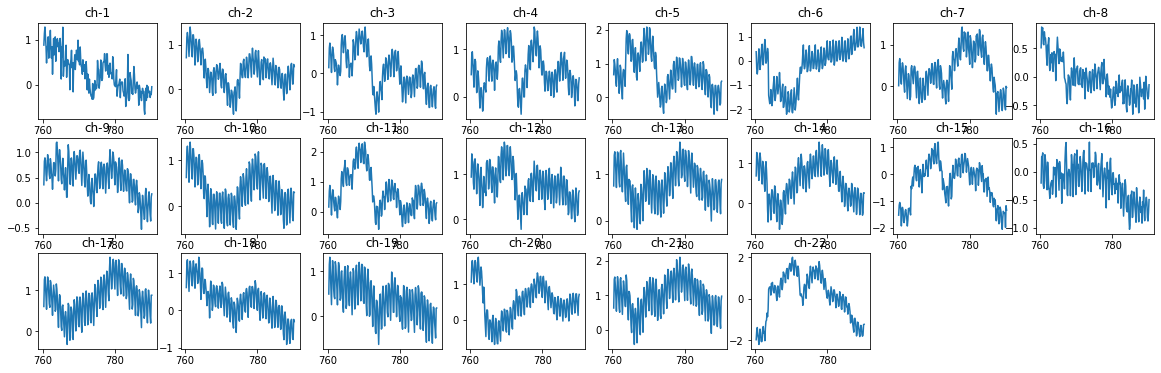





Trial Count -> 8 / 10
Z-normalized Data


,Time(sec),ch-1,ch-2,ch-3,ch-4,ch-5,ch-6,ch-7,ch-8,ch-9,...,ch-13,ch-14,ch-15,ch-16,ch-17,ch-18,ch-19,ch-20,ch-21,ch-22
0,929.10,-0.435429,-0.706322,-1.072975,-0.887268,0.079087,0.625379,-0.703674,-0.263311,0.135704,...,0.839291,-0.223259,-0.542206,0.974073,0.416465,-0.223583,-1.043703,0.492316,0.293417,-0.966904
1,929.25,-0.649499,-0.932899,-1.198883,-1.124720,-0.524925,1.044918,-0.894222,-0.598304,-0.208355,...,0.456679,-0.375891,-0.726281,0.667259,0.084951,-0.537255,-1.297318,0.234749,-0.010078,-1.071705
2,929.40,-0.508482,-1.392858,-1.617629,-1.519601,-1.242104,1.486490,-1.113849,-0.644836,-0.693471,...,-0.200275,-0.619243,-0.904141,0.278640,-0.663828,-1.040702,-1.902792,-0.314637,-0.510611,-1.190340
3,929.55,-0.514352,-1.698602,-1.897021,-1.989708,-1.361748,2.099802,-1.429948,-0.484806,-1.028388,...,-0.789333,-0.727400,-1.010254,0.468811,-1.214351,-1.589841,-2.410021,-0.826510,-1.015309,-1.341212
4,929.70,-0.654717,-1.230762,-1.591992,-1.457894,-0.309499,1.618389,-1.002439,-0.781285,-0.517897,...,0.000818,-0.450854,-0.899480,0.535794,-0.254109,-0.693666,-1.466476,-0.185922,-0.339212,-1.141398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,958.35,-1.422027,-2.650940,-1.317841,-0.669222,-1.172227,0.293671,-0.998106,-2.232400,-1.255273,...,-1.067040,-1.853816,-1.644007,-0.778272,-1.444507,-1.311659,-1.051336,-0.744415,-1.364875,-1.661554
196,958.50,-1.635574,-2.825395,-1.534564,-0.773011,-0.740352,0.668842,-1.214768,-2.133049,-1.327294,...,-1.217210,-1.948080,-1.763281,-0.599265,-1.613266,-1.246417,-1.235022,-0.887402,-1.435543,-1.780515
197,958.65,-1.209653,-2.135635,-0.864456,0.115744,0.099368,-0.511300,-0.202158,-1.848832,-0.232984,...,0.206651,-1.454009,-1.398604,0.014556,-0.246906,-0.323890,-0.263653,0.101276,-0.308758,-1.414821
198,958.80,-1.197130,-1.891327,-0.680322,0.218007,0.122888,-0.777210,-0.492143,-1.567758,-0.100510,...,0.382206,-1.345945,-1.460846,-0.005654,-0.093069,-0.172367,-0.171810,0.288437,-0.274530,-1.456780



Summary Statistics


,ch-1,ch-2,ch-3,ch-4,ch-5,ch-6,ch-7,ch-8,ch-9,ch-10,...,ch-13,ch-14,ch-15,ch-16,ch-17,ch-18,ch-19,ch-20,ch-21,ch-22
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,-0.045515,-1.340636,-0.165276,0.389095,2.203178,-1.555882,-0.091897,-2.311327,3.041441,0.115854,...,-0.337625,-0.629272,-0.979257,3.349679,1.245234,1.984666,0.560602,-0.849240,0.119583,-0.952158
std,1.103729,1.040671,1.572822,1.428962,2.461237,1.696056,0.939601,1.944338,3.030118,1.207887,...,0.907118,0.953072,1.330589,3.074939,2.104141,2.599044,1.677600,0.942450,1.017887,0.700273
min,-2.850330,-3.146722,-2.312349,-8.067303,-1.638189,-4.844928,-3.130289,-10.044147,-1.476933,-2.609112,...,-5.081865,-5.090595,-9.203067,-2.066932,-6.798125,-2.022946,-6.471303,-5.002089,-2.235927,-4.515915
25%,-0.898692,-2.229669,-1.371766,-0.537031,0.094298,-3.173789,-0.834298,-2.991637,0.135470,-0.938118,...,-0.978612,-1.365339,-1.895694,0.721442,-0.248707,-0.333825,-0.709634,-1.292136,-0.590910,-1.445344
50%,-0.093127,-1.366439,-0.829817,0.507900,1.652177,-1.251078,-0.140524,-2.136508,2.578169,0.058864,...,-0.257698,-0.618404,-1.422642,2.327791,1.036789,1.356997,0.516027,-0.676795,-0.005588,-1.118950
75%,0.733701,-0.564600,1.002182,1.366837,4.175810,-0.171972,0.749729,-0.782936,6.172317,1.297768,...,0.320770,0.142143,0.255629,6.543554,2.843609,4.509337,1.841287,-0.158772,0.730635,-0.358424
max,4.547520,1.047720,3.906742,3.293328,7.913007,2.115196,1.696029,1.001522,8.107649,2.252775,...,1.217621,0.989216,1.420106,9.043254,5.470982,6.957508,3.832100,0.633128,2.371943,0.360468


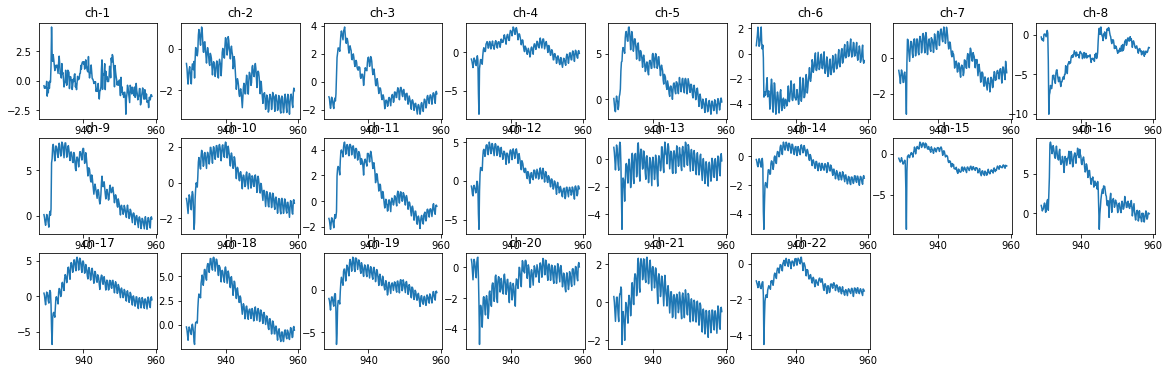





Trial Count -> 9 / 10
Z-normalized Data


,Time(sec),ch-1,ch-2,ch-3,ch-4,ch-5,ch-6,ch-7,ch-8,ch-9,...,ch-13,ch-14,ch-15,ch-16,ch-17,ch-18,ch-19,ch-20,ch-21,ch-22
0,929.25,-0.647852,-0.928330,-1.193559,-1.122428,-0.522486,1.042256,-0.894981,-0.605969,-0.202053,...,0.464370,-0.370669,-0.726488,0.668025,0.094720,-0.534070,-1.304859,0.238894,-0.000439,-1.077965
1,929.40,-0.506879,-1.389730,-1.613812,-1.520220,-1.248055,1.486329,-1.117908,-0.652722,-0.693915,...,-0.197122,-0.617136,-0.907594,0.279223,-0.664900,-1.043884,-1.920782,-0.312333,-0.509618,-1.198995
2,929.55,-0.512747,-1.696431,-1.894210,-1.993793,-1.369098,2.103113,-1.438757,-0.491931,-1.033489,...,-0.790248,-0.726677,-1.015643,0.469483,-1.223392,-1.599967,-2.436764,-0.825921,-1.023034,-1.352911
3,929.70,-0.653068,-1.227126,-1.588083,-1.458058,-0.304539,1.618974,-1.004824,-0.789821,-0.515899,...,0.005359,-0.446592,-0.902848,0.536498,-0.249249,-0.692459,-1.476937,-0.183186,-0.335258,-1.149065
4,929.85,-0.058922,-0.986544,-1.098301,-0.742427,0.355163,0.569955,-0.678767,0.057255,0.157574,...,1.019463,-0.161218,-0.475117,1.016579,0.582226,-0.219229,-0.858259,0.500733,0.265669,-1.001806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,958.50,-1.633617,-2.826752,-1.530448,-0.768126,-0.740432,0.664051,-1.220344,-2.148016,-1.336552,...,-1.221080,-1.962981,-1.782412,-0.599096,-1.628082,-1.252200,-1.241489,-0.887017,-1.450528,-1.801080
196,958.65,-1.207830,-2.134832,-0.857928,0.127182,0.109111,-0.522772,-0.192516,-1.862446,-0.227025,...,0.212615,-1.462586,-1.411080,0.015015,-0.241942,-0.318007,-0.253358,0.104974,-0.304278,-1.428005
197,958.80,-1.195310,-1.889759,-0.673130,0.230199,0.132906,-0.790187,-0.486859,-1.580035,-0.092708,...,0.389382,-1.353139,-1.474457,-0.005205,-0.085877,-0.164568,-0.159930,0.292762,-0.269459,-1.470812
198,958.95,-1.332762,-2.016608,-0.847636,-0.133986,-0.287469,-0.575587,-0.832709,-1.643056,-0.330694,...,-0.128602,-1.534354,-1.498561,-0.080693,-0.515272,-0.553008,-0.334763,0.009102,-0.496379,-1.541179



Summary Statistics


,ch-1,ch-2,ch-3,ch-4,ch-5,ch-6,ch-7,ch-8,ch-9,ch-10,...,ch-13,ch-14,ch-15,ch-16,ch-17,ch-18,ch-19,ch-20,ch-21,ch-22
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,-0.052592,-1.345375,-0.156611,0.403171,2.231701,-1.576773,-0.082815,-2.337231,3.088215,0.127043,...,-0.343643,-0.634586,-0.989788,3.346362,1.263495,2.015660,0.585659,-0.853508,0.124216,-0.959565
std,1.112971,1.045187,1.578715,1.438965,2.496445,1.701843,0.955686,1.948111,3.077529,1.225865,...,0.910058,0.967655,1.355391,3.081463,2.141112,2.636024,1.706048,0.941175,1.039292,0.716252
min,-2.847990,-3.149085,-2.311033,-8.116197,-1.648773,-4.880933,-3.164651,-10.096753,-1.488273,-2.628849,...,-5.112427,-5.145717,-9.357963,-2.067453,-6.888003,-2.038549,-6.568127,-5.015492,-2.264738,-4.591684
25%,-0.911572,-2.248700,-1.367064,-0.530406,0.100619,-3.200333,-0.840754,-3.010689,0.138136,-0.942299,...,-0.980835,-1.374977,-1.917241,0.706780,-0.272737,-0.359003,-0.707034,-1.293107,-0.619239,-1.461775
50%,-0.091655,-1.383261,-0.823164,0.522229,1.680086,-1.266737,-0.129955,-2.155677,2.623222,0.072173,...,-0.268953,-0.618883,-1.462033,2.329339,1.060338,1.384135,0.539777,-0.675704,-0.003351,-1.133986
75%,0.734912,-0.558878,1.015431,1.387499,4.233242,-0.181522,0.773676,-0.801983,6.267353,1.326421,...,0.317051,0.153996,0.273341,6.547088,2.893316,4.576337,1.887905,-0.157343,0.753070,-0.350290
max,4.547531,1.058491,3.930448,3.328193,8.014159,2.118593,1.734198,1.001468,8.229599,2.293257,...,1.230567,1.011910,1.459068,9.047965,5.558726,7.055467,3.913072,0.638608,2.422731,0.383111


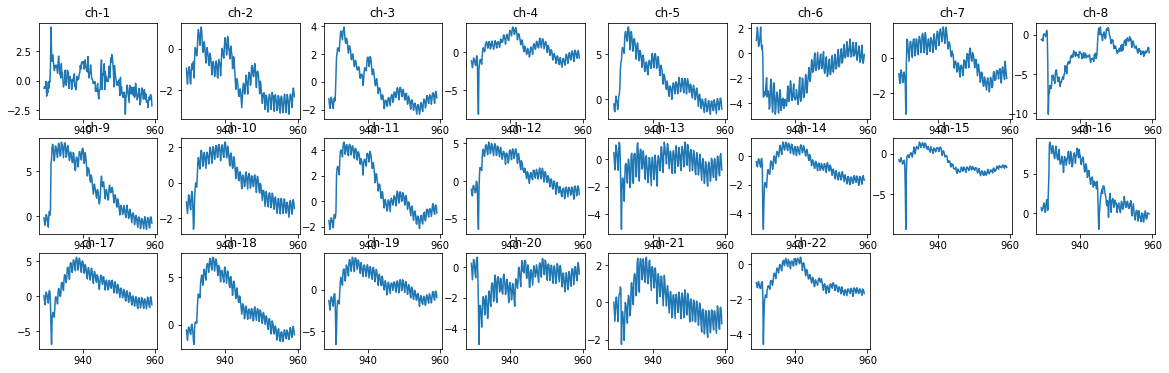





Trial Count -> 10 / 10
Z-normalized Data


,Time(sec),ch-1,ch-2,ch-3,ch-4,ch-5,ch-6,ch-7,ch-8,ch-9,...,ch-13,ch-14,ch-15,ch-16,ch-17,ch-18,ch-19,ch-20,ch-21,ch-22
0,1101.90,-1.760941,-0.248948,-0.409801,-1.352849,-1.418872,1.707106,-2.240112,-1.416877,-2.243058,...,-1.558761,-2.436992,-2.698977,-3.173593,-2.181785,-0.503160,-0.922187,-1.204851,-2.016189,-2.546673
1,1102.05,-1.372067,0.063460,-0.300223,-1.049017,-0.900994,1.453302,-1.885262,-1.109859,-1.774744,...,-1.061503,-1.447083,-2.607976,-3.069966,-1.522182,0.256403,-0.010650,-0.597540,-1.220000,-2.038951
2,1102.20,-1.248930,0.396857,0.047590,-0.753555,-0.789998,0.879341,-1.724965,-0.755396,-1.388511,...,-0.351242,-0.751812,-2.272560,-2.510679,-0.764453,0.545206,0.463178,0.000888,-0.348569,-2.002267
3,1102.35,-1.493124,0.435606,0.071310,-0.946456,-0.840715,0.951169,-1.697088,-0.633378,-1.448725,...,-0.377513,-0.837760,-2.340811,-1.912240,-0.931095,0.587644,0.432188,-0.049909,-0.455122,-1.865948
4,1102.50,-1.067284,0.055792,-0.140497,-1.061904,-0.987128,1.152056,-2.021461,-0.974456,-1.900408,...,-0.854832,-1.224662,-2.979403,-2.851549,-1.397636,-0.027518,-0.264555,-0.447777,-0.965520,-2.269043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1131.15,1.401089,2.035185,0.309159,-0.137389,-0.859609,0.928443,0.874866,1.402810,0.405127,...,-0.085792,2.130870,-0.503873,-1.452081,-0.307347,-0.722297,-0.143373,0.894214,-0.048880,-1.945829
196,1131.30,1.464861,1.404112,-0.131087,-0.510436,-1.107610,1.189546,0.380509,1.136904,0.100669,...,-0.469273,1.389742,-1.027252,-1.697655,-0.686357,-1.263286,-0.722141,0.510484,-0.642827,-2.265462
197,1131.45,1.393378,1.369198,-0.251880,-0.295615,-1.024841,1.281612,0.223402,1.464835,-0.052407,...,-0.609038,1.498756,-1.013748,-1.825773,-0.642665,-1.188550,-0.532139,0.466819,-0.595381,-2.086815
198,1131.60,1.539649,2.136899,0.492863,0.065742,-0.587360,0.660705,0.703938,1.238128,0.767181,...,0.306760,2.782480,-0.333063,-1.228333,0.324675,-0.479500,0.328532,1.281071,0.689480,-1.665920



Summary Statistics


,ch-1,ch-2,ch-3,ch-4,ch-5,ch-6,ch-7,ch-8,ch-9,ch-10,...,ch-13,ch-14,ch-15,ch-16,ch-17,ch-18,ch-19,ch-20,ch-21,ch-22
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.419568,1.007391,-0.309050,-0.976631,-1.202814,1.250269,0.071557,0.633035,-0.275204,0.327662,...,-0.428767,1.194228,-1.496003,-1.464525,-0.464705,-0.469194,-0.833530,0.343178,-0.412399,-1.814996
std,1.001576,1.057982,0.651332,0.495996,0.388258,0.406558,1.369247,0.747465,1.042726,0.851916,...,0.598427,1.557312,1.271216,0.662981,0.984376,0.461041,0.696801,1.186985,0.838442,0.762024
min,-2.330236,-0.996669,-1.881756,-2.015912,-2.006057,0.118594,-2.852122,-1.416877,-2.652082,-1.291899,...,-1.767039,-2.628659,-3.633688,-3.305377,-2.430587,-1.541197,-2.672809,-2.102056,-2.153254,-3.161410
25%,-0.225001,0.140553,-0.840604,-1.315551,-1.479840,1.005123,-0.909602,0.211608,-1.092446,-0.314790,...,-0.851146,0.025562,-2.604600,-1.821774,-1.222175,-0.785390,-1.314266,-0.689406,-0.993875,-2.424898
50%,0.411218,0.845087,-0.300481,-1.026299,-1.196383,1.251835,-0.142552,0.675660,-0.372188,0.243358,...,-0.405013,1.414318,-1.957766,-1.388855,-0.517320,-0.478936,-0.825049,0.460125,-0.387228,-2.030703
75%,1.212925,2.020704,0.181823,-0.670855,-0.908318,1.528697,1.310720,1.124684,0.695956,1.002340,...,0.015370,2.533493,-0.165720,-1.031658,0.311284,-0.106948,-0.318414,1.380350,0.101444,-1.201421
max,2.558284,2.929019,1.038433,0.382859,-0.406446,2.134259,2.489527,2.228018,1.530251,2.187089,...,0.763289,3.866850,0.816864,0.659116,1.753909,0.587644,0.586925,2.592783,1.400204,-0.034870


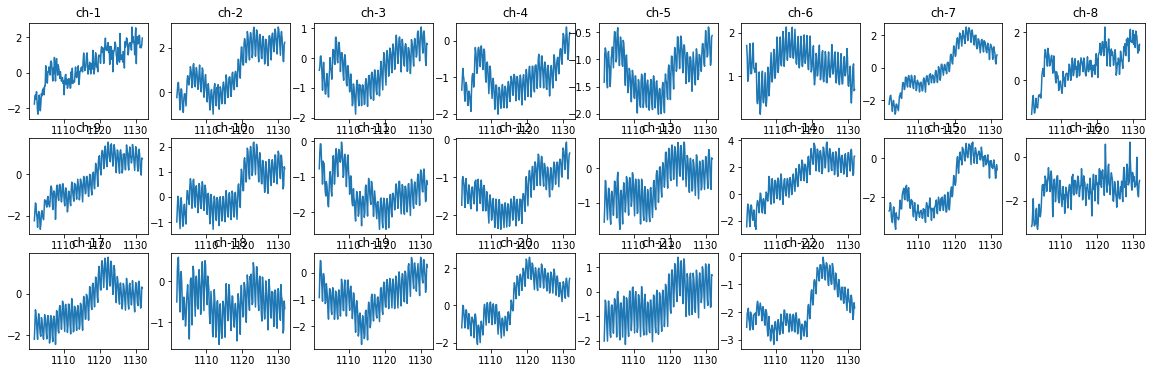

In [4]:
# define constants.
measurement_period = 0.15     # [sec]
preceding_rest_duration = 45  # [sec]
task_duration = 30            # [sec]
following_rest_duration = 45  # [sec]
num_preceding_rest_samples = int(preceding_rest_duration/measurement_period)
num_task_samples = int(task_duration/measurement_period)
num_following_rest_samples = int(following_rest_duration/measurement_period)
num_columns = 70
separation_char = '\t'
data_table_start_row_index = 33
marker_string = "1"
filepath = './experimental_data/txt/0713-main.TXT'
print('filepath -> {}'.format(filepath))

# load text file and make dataframe object
temporary_names = np.arange(num_columns).astype(str)
temporary_df = pd.read_csv(filepath, names=temporary_names, sep=separation_char)
# display(temporary_df)

# create dataframe object that contains oxy-hb data
oxy_data = temporary_df[[temporary_names[0], temporary_names[2], *temporary_names[4::3]]][data_table_start_row_index:].values
oxy_df_column_labels = [*oxy_data[1][:2], *[label.replace(' ', '') for label in oxy_data[0][2:]]]
oxy_df = pd.DataFrame(oxy_data[2:], columns=oxy_df_column_labels)
print(' Oxy-Hb data')
display(oxy_df)

# find marker index where its value is not equal to <marker_string>
finding_marker_query_statement = 'Mark=="{}"'.format(marker_string)
marker_indexes = oxy_df.query(finding_marker_query_statement).index.values
num_markers = marker_indexes.shape[0]
print('\nMarker Indexes -> {}'.format(marker_indexes))
print('\n\n')
# for each trial, caluculate z-scores of task samples and create dataframe.
for n, marker_index in enumerate(marker_indexes):
    time_label = oxy_df_column_labels[0]
    channel_labels = oxy_df_column_labels[2:]
    preceding_rest_samples = oxy_df[channel_labels][
        marker_index
        :marker_index+num_preceding_rest_samples
    ]
    preceding_rest_sample_averages = np.average(preceding_rest_samples.values.astype(float), axis=0)
    preceding_rest_sample_stds = np.std(preceding_rest_samples.values.astype(float), axis=0)
    task_times = oxy_df[time_label][
        marker_index+num_preceding_rest_samples
        :marker_index+num_preceding_rest_samples+num_task_samples
    ].values.astype(float)
    task_samples = oxy_df[channel_labels][
        marker_index+num_preceding_rest_samples
        :marker_index+num_preceding_rest_samples+num_task_samples
    ].values.astype(float)
    z_normalized_task_samples = ((task_samples - preceding_rest_sample_averages) / preceding_rest_sample_stds)
    z_normalized_task_samples_with_times = np.hstack([np.expand_dims(task_times, axis=1), z_normalized_task_samples])
    z_normalized_task_sample_df_column_labels = [oxy_df_column_labels[0], *oxy_df_column_labels[2:]]
    z_normalized_task_sample_df = pd.DataFrame(
        z_normalized_task_samples_with_times, 
        columns=z_normalized_task_sample_df_column_labels
    )
    print('Trial Count -> {} / {}'.format(n+1, num_markers))
    print('Z-normalized Data')
    display(z_normalized_task_sample_df)

    # check summary statistics
    print('\nSummary Statistics')
    display(z_normalized_task_sample_df[z_normalized_task_sample_df_column_labels[1:]].describe())
    
    # visualize data
    plt.figure(figsize=(20,6))
    for i, channel_label in enumerate(channel_labels):
        z_normalized_task_samples = z_normalized_task_sample_df[channel_label]
        plt.subplot(3,8,i+1)
        plt.title(channel_label)
        plt.plot(task_times, z_normalized_task_samples)
    plt.show()
    print('\n\n\n')